In [21]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import periodogram
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [22]:
# Load the dataset
df=pd.read_csv('medical_time_series.csv')

In [23]:
# Display basic information
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Day      731 non-null    int64  
 1   Revenue  731 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 11.6 KB
None
   Day   Revenue
0    1  0.000000
1    2 -0.292356
2    3 -0.327772
3    4 -0.339987
4    5 -0.124888


In [24]:
# Convert 'Day' column into a proper datetime index (assuming start date is 2020-01-01)
df['Date'] = pd.to_datetime(df['Day'], origin='2020-01-01', unit='D')
df.set_index('Date', inplace=True)
df.drop(columns=['Day'], inplace=True)

In [25]:
# Save the cleaned dataset
df.to_csv('cleaned_time.csv', index=False)

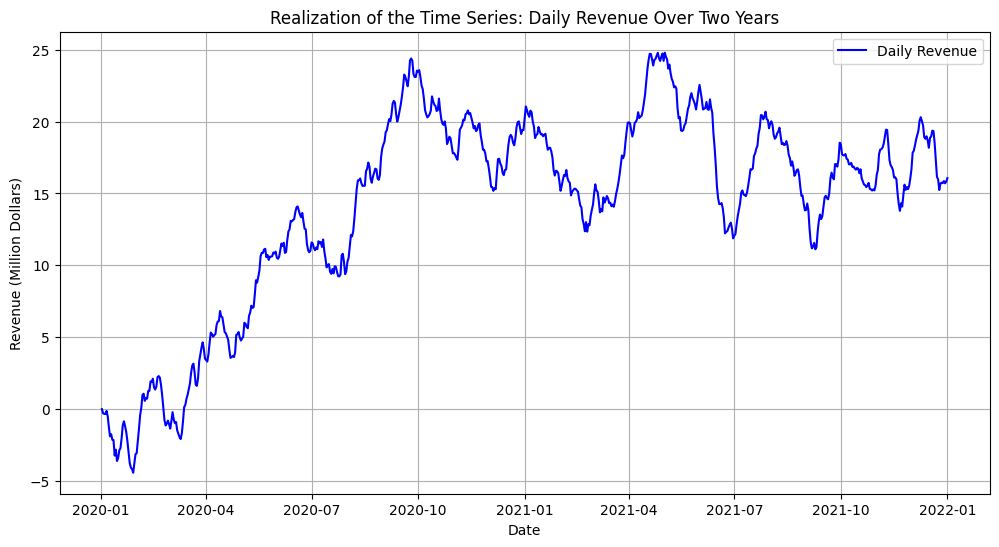

In [26]:
# Plot the realization of the time series (original revenue data)
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Revenue'], label="Daily Revenue", color='blue')
plt.xlabel("Date")
plt.ylabel("Revenue (Million Dollars)")
plt.title("Realization of the Time Series: Daily Revenue Over Two Years")
plt.legend()
plt.grid(True)
plt.show()

In [27]:
# Check for stationarity using Augmented Dickey-Fuller Test
def adf_test(series):
    result = adfuller(series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    if result[1] <= 0.05:
        print("The data is stationary.")
    else:
        print("The data is not stationary.")

print("Original Data Stationarity Test:")
adf_test(df["Revenue"])

Original Data Stationarity Test:
ADF Statistic: -2.218319047608948
p-value: 0.19966400615064245
Critical Values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
The data is not stationary.


In [28]:
# Apply differencing if needed
df["Revenue_Diff"] = df["Revenue"].diff()
print("After Differencing Stationarity Test:")
adf_test(df["Revenue_Diff"].dropna())

# Split data into training and testing sets
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

After Differencing Stationarity Test:
ADF Statistic: -17.374772303557062
p-value: 5.113206978840171e-30
Critical Values: {'1%': -3.4393520240470554, '5%': -2.8655128165959236, '10%': -2.5688855736949163}
The data is stationary.


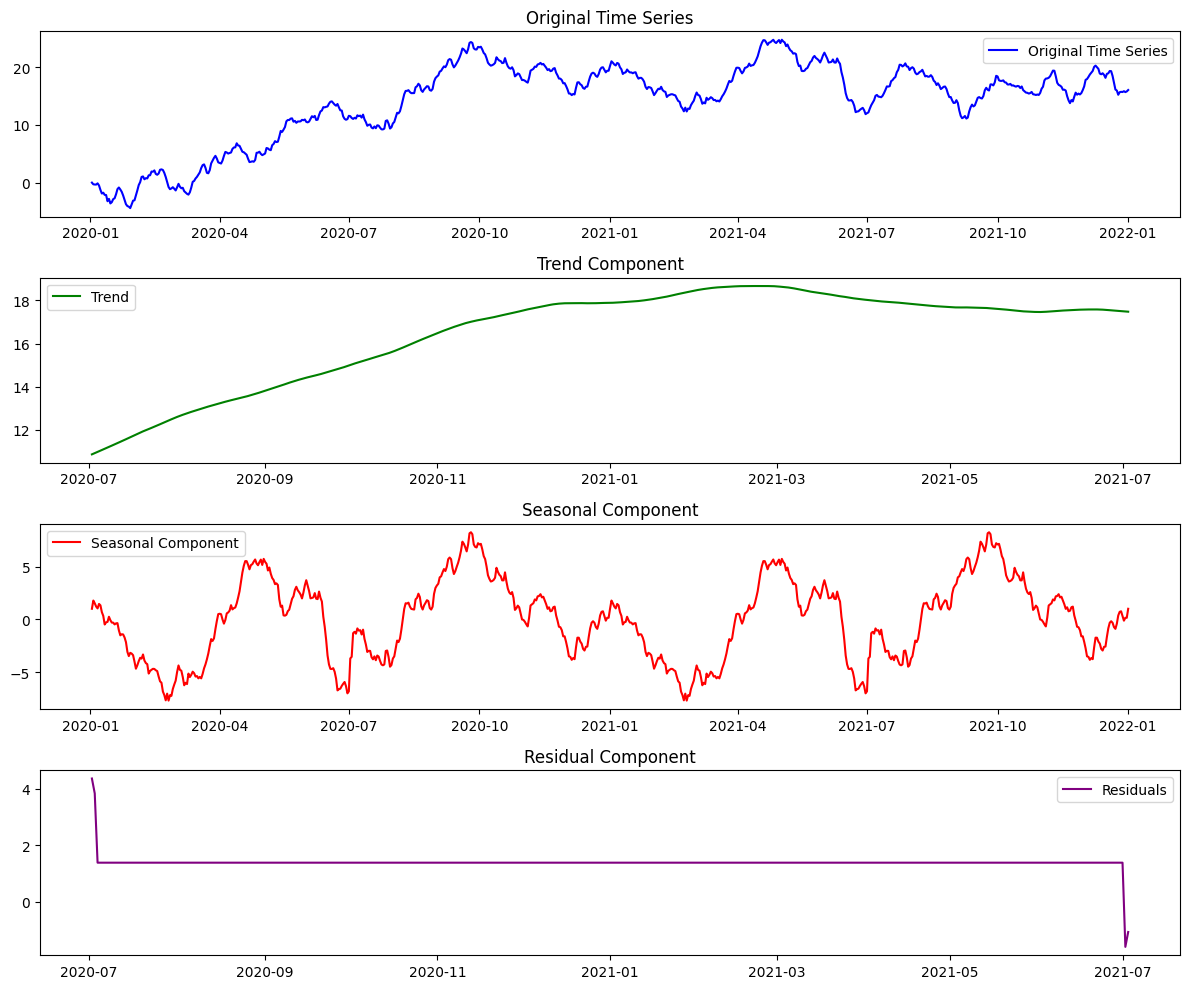

In [29]:
# ----------- Decomposing the Time Series -----------
decomposition = seasonal_decompose(df['Revenue'], model='additive', period=365)  # Assuming yearly seasonality

# Plot the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(12, 10))
axes[0].plot(df.index, df['Revenue'], label="Original Time Series", color='blue')
axes[0].set_title("Original Time Series")
axes[0].legend()

axes[1].plot(decomposition.trend, label="Trend", color='green')
axes[1].set_title("Trend Component")
axes[1].legend()

axes[2].plot(decomposition.seasonal, label="Seasonal Component", color='red')
axes[2].set_title("Seasonal Component")
axes[2].legend()

axes[3].plot(decomposition.resid, label="Residuals", color='purple')
axes[3].set_title("Residual Component")
axes[3].legend()

plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

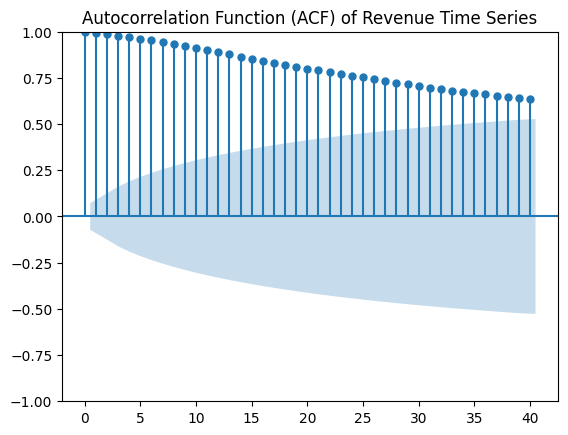

In [30]:
# Plot ACF
plt.figure(figsize=(12, 6))
plot_acf(df['Revenue'].dropna(), lags=40)
plt.title("Autocorrelation Function (ACF) of Revenue Time Series")
plt.show()

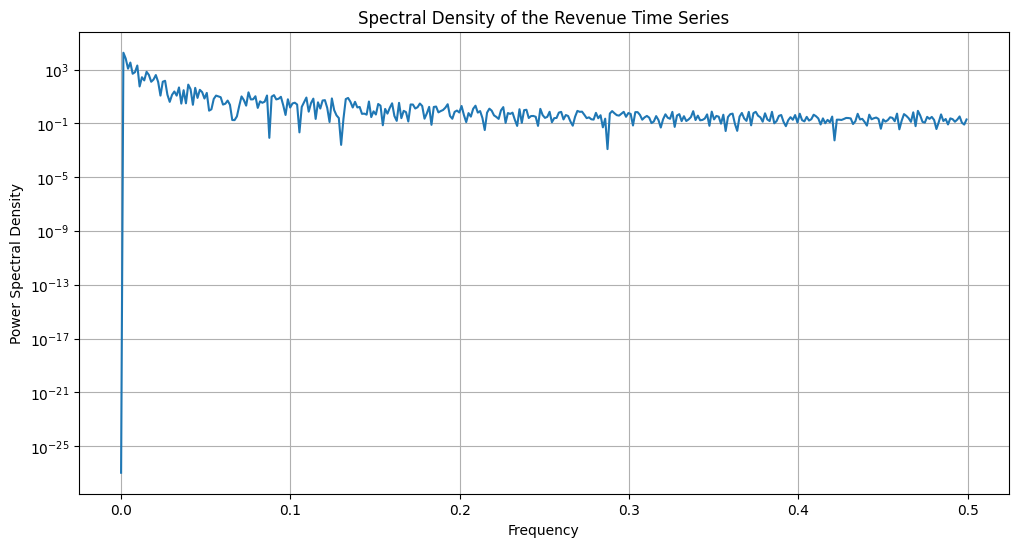

In [31]:
# Spectral Density Plot
frequencies, power_spectral_density = periodogram(df['Revenue'].dropna(), scaling='density')

plt.figure(figsize=(12, 6))
plt.semilogy(frequencies, power_spectral_density)
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.title("Spectral Density of the Revenue Time Series")
plt.grid(True)
plt.show()

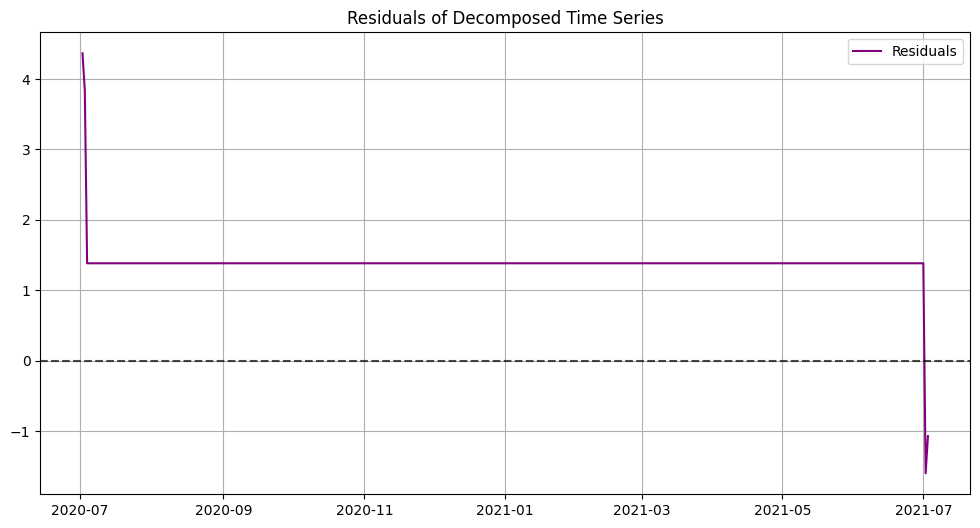

In [32]:
# Visualization 4: Checking Residuals for Trends
plt.figure(figsize=(12, 6))
plt.plot(decomposition.resid, label="Residuals", color='purple')
plt.axhline(y=0, linestyle='--', color='black', alpha=0.7)
plt.title("Residuals of Decomposed Time Series")
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Fit ARIMA model (ARIMA(1,1,1))
model = ARIMA(train["Revenue"], order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())

/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/Users/admin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                Revenue   No. Observations:                  584
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -350.568
Date:                Thu, 17 Apr 2025   AIC                            707.136
Time:                        22:01:06   BIC                            720.240
Sample:                    01-02-2020   HQIC                           712.244
                         - 08-07-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4596      0.098      4.714      0.000       0.269       0.651
ma.L1         -0.0587      0.108     -0.544      0.587      -0.270       0.153
sigma2         0.1948      0.012     15.667      0.0

In [34]:
# Forecast
forecast_steps = len(test)
forecast = model_fit.forecast(steps=forecast_steps)

# Evaluate the model
mae = mean_absolute_error(test["Revenue"], forecast)
mse = mean_squared_error(test["Revenue"], forecast)
rmse = np.sqrt(mse)
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

Mean Absolute Error (MAE): 2.998201861803443
Mean Squared Error (MSE): 12.774956687106753
Root Mean Squared Error (RMSE): 3.574207141046354


In [35]:
# Forecast for the length of the test set
forecast = model_fit.get_forecast(steps=len(test))
forecast_values = forecast.predicted_mean
conf_int = forecast.conf_int()

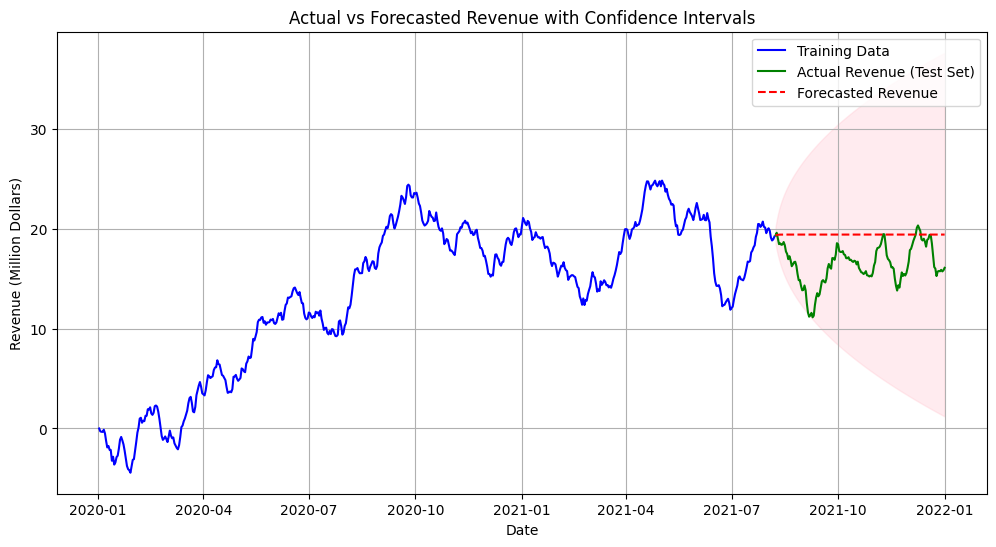

In [36]:
# Plot actual vs forecasted
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['Revenue'], label='Training Data', color='blue')
plt.plot(test.index, test['Revenue'], label='Actual Revenue (Test Set)', color='green')
plt.plot(test.index, forecast_values, label='Forecasted Revenue', color='red', linestyle='--')
plt.fill_between(test.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.xlabel('Date')
plt.ylabel('Revenue (Million Dollars)')
plt.title('Actual vs Forecasted Revenue with Confidence Intervals')
plt.legend()
plt.grid(True)
plt.show()